## Getting started (Adjust settings to your experiment's needs)

In [21]:
import os
import sys
import logging
from beir import util
from beir.datasets.data_loader import GenericDataLoader
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from ir_measures import nDCG, AP, P, R, RR
from IRutils import dataprocessor, models, train, inference
from IRutils.dataset import TripletRankingDataset
from transformers import AutoTokenizer

#################### THINGS TO CHANGE FOR YOUR EXPERIMENTS ####################

dataset_name = "quora"  # SELECT YOUR EXPERIMENT DATASET HERE
model_name = "distilbert-base-uncased"  # SELECT YOUR MODEL HERE

# Create dataset for a specific query length range (e.g., short queries)
length_setting = 'full'

metrics = [nDCG@10, nDCG@100, AP@10, AP@100, P@10, R@10, P@100, R@100, RR]

#################### THINGS TO CHANGE FOR YOUR EXPERIMENTS ####################

logging.disable(logging.WARNING)

datasets = {'msmarco': ['train', 'dev'],
            'hotpotqa': ['train', 'dev', 'test'],
            'arguana': ['test'],
            'quora': ['dev', 'test'],
            'scidocs': ['test'],  # small
            'fever': ['train', 'dev', 'test'],  # large
            'climate-fever': ['test'],
            'scifact': ['train', 'test'],
            'fiqa': ['train', 'dev', 'test'],
            'nfcorpus': ['train', 'dev', 'test']
            }

max_len_doc = 512  # max token length
random_state = 42

In [22]:
# Download and unzip the dataset
url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset_name}.zip"
data_path = util.download_and_unzip(url, "datasets")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_available = False
if 'train' in datasets[dataset_name]:
    # Load the dataset
    docs, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="train")
    docs_test, queries_test, qrels_test = GenericDataLoader(data_folder=data_path).load(split="test")
    train_available = True
    print('Train and test set available!')
else:
    # Load the dataset
    docs, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")
    print('Only test set available!')

  0%|          | 0/522931 [00:00<?, ?it/s]

Only test set available!


In [23]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

## Data visualization

In [24]:
import numpy as np

def calculate_percentiles(query_lengths):
    # Calculate the 25th, and 75th percentiles
    t1 = np.percentile(query_lengths, 25)
    t2 = np.percentile(query_lengths, 75)
    return int(t1), int(t2)

t1: 7
t2: 11


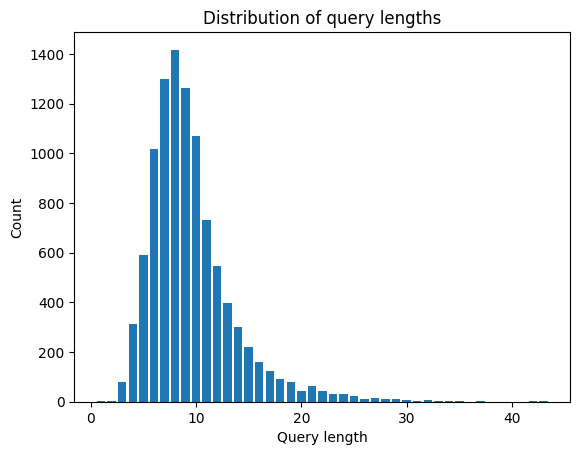

In [25]:
import matplotlib.pyplot as plt
from collections import Counter

query_lengths = [len(txt.split()) for txt in list(queries.values())]
t1, t2 = calculate_percentiles(query_lengths)
print(f't1: {t1}')
print(f't2: {t2}')
ranges = {'short': (1, t1), 'medium': (t1, t2), 'long': (t2, sys.maxsize), 'full': (1, sys.maxsize)}

counts = Counter(query_lengths)
text_lengths = list(set(query_lengths))

counts = [counts[length] for length in text_lengths]
# Create bar chart
plt.bar(text_lengths, counts)

# Add labels
plt.xlabel("Query length")
plt.ylabel("Count")
plt.title("Distribution of query lengths")

# Display plot
plt.show()


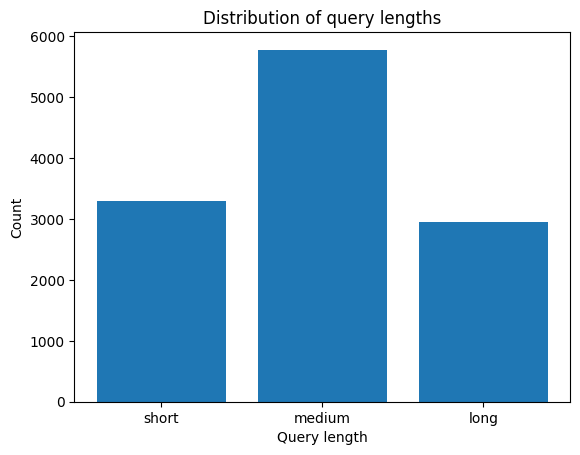

In [28]:
short = {qid: q for qid, q in queries.items() if 1 <= len(q.split()) <= t1}
medium = {qid: q for qid, q in queries.items() if t1 <= len(q.split()) <= t2}
long = {qid: q for qid, q in queries.items() if t2 <= len(q.split())}

counts = [len(short), len(medium), len(long)]

# Create bar chart
plt.bar(list(ranges.keys())[:3], counts)

# Add labels
plt.xlabel("Query length")
plt.ylabel("Count")
plt.title("Distribution of query lengths")

# Display plot
plt.show()

### Get test split (if no seperate test set available)

In [29]:
dp = dataprocessor.DataProcessor(queries, docs, qrels)

print(f'Dataset size: {len(queries)}')

# first seperate the test set (include queries of all lengths)
if not train_available:
    query_test, qrel_test = dp.get_testset(test_ratio=0.2, random_state=random_state)
    print(f'test size: {len(query_test)}')
else:
    print(f'test size: {len(queries_test)}')

Dataset size: 10000
test size: 2000


### Query length filtering

In [30]:
# filter by query length
print(f'Length range: {ranges[length_setting]}')
query_subset, qrels_subset = dp.get_subset(ranges[length_setting][0], ranges[length_setting][1])  # Adjust min/max length

Length range: (1, 9223372036854775807)


### Train Val split

In [31]:
print(f'Example query from {length_setting} subset:\n{query_subset.popitem()}')

query_train, query_val, qrel_train, qrel_val = dp.train_val_split(train_ratio=0.8, val_ratio=0.2, train_available=train_available, random_state=42)  # adjust if needed

print(f'Length of subset of {length_setting} validation queries: {len(query_val)}')
print(f'Length of subset of {length_setting} training queries: {len(query_train)}')
print(f'Length of subset of {length_setting} queries: {len(query_subset)}')

Example query from full subset:
('537876', 'How do Russian politics and geostrategy affect Australia and New Zealand?')
Length of subset of full validation queries: 1600
Length of subset of full training queries: 6399
Length of subset of full queries: 7999


### Check if the qrels already contain negative samples （If not create later)

In [32]:
qrel_scores = list(qrels.values()) 
relevance_scores = [list(item.values()) for item in qrel_scores]
num_negatives = relevance_scores[0].count(0)
print(f'Number of negatives in qrels: {num_negatives}')

Number of negatives in qrels: 0


### Create datasets and data loaders

In [ ]:
print('Creating training dataset...')
train_dataset = TripletRankingDataset(query_train, docs, qrel_train, tokenizer, num_negatives, max_length=max_len_doc)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

print('Creating validation dataset...')
val_dataset = TripletRankingDataset(query_val, docs, qrel_val, tokenizer, num_negatives,max_length=max_len_doc)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

print('Creating testing dataset...')
if train_available:
    test_dataset = TripletRankingDataset(queries_test, docs_test, qrels_test, tokenizer, num_negatives,max_length=max_len_doc)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
else:
    test_dataset = TripletRankingDataset(query_test, docs, qrel_test, tokenizer, num_negatives,max_length=max_len_doc) 
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

Creating training dataset...


 25%|██▍       | 1568/6399 [00:46<02:23, 33.73it/s]

### Initialize model

In [ ]:
# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.TripletRankerModel(model_name).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
model_path = os.path.join(os.getcwd(), f'models/{model_name}+{dataset_name}+{length_setting}_queries.pth')

### Train model (load directly if already trained)

In [ ]:
print(model_path)
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    # Train the model
    model = train.train_triplet_ranker(model, train_loader, val_loader, optimizer, device, model_path)

## Run inference on test set

In [ ]:
# Example usage (replace with your data and model)
if train_available:
    metric_scores = inference.evaluate(model, test_loader, device, qrels_test)
else:
    metric_scores = inference.evaluate(model, test_loader, device, qrel_test)
    
for metric in metrics:
    print(f'Metric {metric} score: {metric_scores[metric]:.4f}')

## Write results to output

In [ ]:
# Save results to a file
with open(f"results/{model_name}+{dataset_name}+{length_setting}_queries.txt", "w") as f:
    f.write(f"Evaluation Results for {model_name} model finetuned on {length_setting} queries from {dataset_name} dataset:\n")
    f.write(f"normalized Discounted Cumulative Gain@10: {metric_scores[nDCG@10]:.4f}\n")
    f.write(f"normalized Discounted Cumulative Gain@100: {metric_scores[nDCG@100]:.4f}\n")
    f.write(f"\n")
    f.write(f"[Mean] Average Precision@10: {metric_scores[AP@10]:.4f}\n")
    f.write(f"[Mean] Average Precision@100: {metric_scores[AP@100]:.4f}\n")
    f.write(f"\n")
    f.write(f"Precision@10: {metric_scores[P@10]:.4f}\n")
    f.write(f"Recall@10: {metric_scores[R@10]:.4f}\n")
    f.write(f"\n")
    f.write(f"Precision@100: {metric_scores[P@100]:.4f}\n")
    f.write(f"Recall@100: {metric_scores[R@100]:.4f}\n")
    f.write(f"\n")
    f.write(f"[Mean] Reciprocal Rank: {metric_scores[RR]:.4f}\n")
    f.write(f"\n")
    f.write(f"----------------------------------------------------\n")
    f.write(f"\n")
    f.write(f"Explanation of metrics:\n")
    f.write(f"NDCG@k (Normalized Discounted Cumulative Gain: Ranking Quality | Prioritizes highly relevant documents appearing earlier in the ranking.\n")
    f.write(f"MAP (Mean Average Precision): Overall Relevance | Measures ranking precision across all relevant documents. Best for small-scale retrieval tasks.\n")
    f.write(f"Precision@k: Relevance | Measures how many of the top-k documents are relevant. Works well in precision-sensitive applications.\n")
    f.write(f"Recall@k: Coverage | Measures how many relevant documents appear in the top-k results. Important in recall-sensitive tasks.\n")
    f.write(f"MRR (Mean Reciprocal Rank): Single Relevant Result | Focuses on ranking the first relevant document. Good for QA tasks.\n")